In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold

from sklearn.metrics import mutual_info_score, accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score, classification_report
from sklearn.feature_extraction import DictVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from imblearn.under_sampling import RandomUnderSampler

import pickle 

In [2]:
train_data = pd.read_csv('../../data/processed/training.csv',)
test_data = pd.read_csv('../../data/processed/test.csv', )

In [22]:
df_train, df_val = train_test_split(train_data, test_size=0.2, random_state=15)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

y_train = df_train.fraudresult.values
y_val = df_val.fraudresult.values

#del df_train['fraudresult']
#del df_val['fraudresult']

In [4]:
cat_features =  df_train.select_dtypes(include=['object']).columns.to_list()

cat_features = [i for i in cat_features if i not in ['transactionid', 'batchid', 'accountid', 'subscriptionid', 
    'customerid', 'currencycode']]
cat_features

['providerid', 'productid', 'productcategory', 'channelid']

In [5]:
num_features = df_train.select_dtypes(exclude=['object', 'datetime64']).columns.to_list()
num_features = [i for i in num_features if i not in ['transactionstarttime_dom', 
    'transactionstarttime_doy', 'transactionstarttime_min', 'transactionstarttime_wkoyr']]

num_features

['countrycode',
 'amount',
 'value',
 'pricingstrategy',
 'transactionstarttime_dow',
 'transactionstarttime_hr',
 'transactionstarttime_is_wkd',
 'transactionstarttime_mth',
 'transactionstarttime_qtr',
 'transactionstarttime_yr']

In [6]:
cat = df_train[cat_features + num_features].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(cat)

X = dv.transform(cat)

#### Checking different model performance

Using default model paaramters to evaluate accuracy.

In [7]:
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
#models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X, y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.998275 (0.000330)
LDA: 0.998210 (0.000475)
CART: 0.999360 (0.000123)
RF: 0.999347 (0.000255)
NB: 0.996263 (0.000543)
SVM: 0.999490 (0.000148)


Tree based algorithms and SVM seems to perform better here.

Since this is a class imbalance problem, tree based models will be prioritised over SVM.

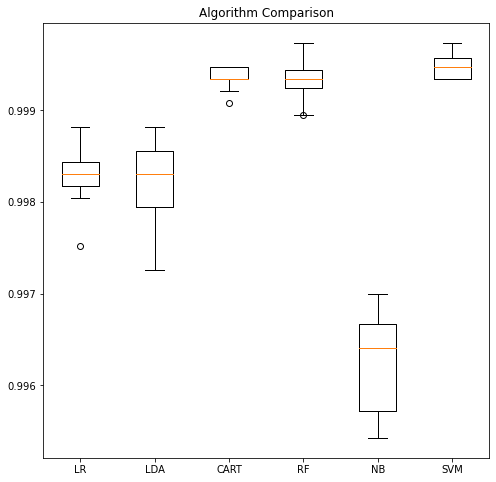

In [8]:
plt.figure(figsize=(8,8))
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [9]:
val_dict = df_val[cat_features + num_features].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [10]:
# Make predictions on validation dataset
dt_model = DecisionTreeClassifier()
dt_model.fit(X, y_train)
dt_predictions = dt_model.predict(X_val)

In [11]:
print(accuracy_score(y_val, dt_predictions))
print(confusion_matrix(y_val, dt_predictions))
print(classification_report(y_val, dt_predictions))

0.9995296085297654
[[19087     4]
 [    5    37]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19091
           1       0.90      0.88      0.89        42

    accuracy                           1.00     19133
   macro avg       0.95      0.94      0.95     19133
weighted avg       1.00      1.00      1.00     19133



0.9403714290702924
0.9403714290702924


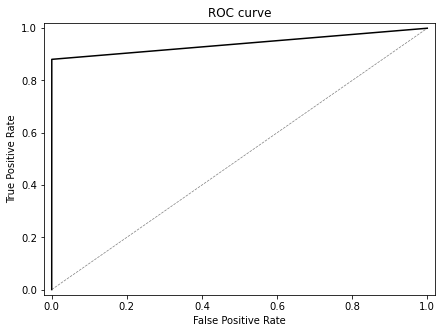

In [12]:
fpr, tpr, thresholds = roc_curve(y_val, dt_predictions)
print(auc(fpr, tpr))

print(roc_auc_score(y_val, dt_predictions))
plt.figure(figsize=(7, 5))

plt.plot(fpr, tpr, color='black')
plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')

plt.show()

In [13]:
# Make predictions on validation dataset
rf_model = RandomForestClassifier()
rf_model.fit(X, y_train)
rf_predictions = rf_model.predict(X_val)

In [14]:
print(accuracy_score(y_val, rf_predictions))
print(confusion_matrix(y_val, rf_predictions))
print(classification_report(y_val, rf_predictions))

0.9996864056865102
[[19090     1]
 [    5    37]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19091
           1       0.97      0.88      0.93        42

    accuracy                           1.00     19133
   macro avg       0.99      0.94      0.96     19133
weighted avg       1.00      1.00      1.00     19133



0.940450000124716
0.940450000124716


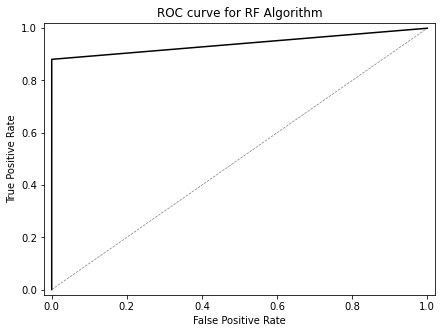

In [15]:
fpr, tpr, thresholds = roc_curve(y_val, rf_predictions)
print(auc(fpr, tpr))

print(roc_auc_score(y_val, rf_predictions))
plt.figure(figsize=(7, 5))

plt.plot(fpr, tpr, color='black')
plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve for RF Algorithm')

plt.show()

Random forest AUC performed better than decision trees.


#### Hyperparamter tuning

In [16]:
def train(df, y, max_depth = 5):
    cat = df[cat_features + num_features].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = RandomForestClassifier(max_depth=max_depth,)
    model.fit(X, y)

    return dv, model


def predict(df, dv, model):
    cat = df[cat_features + num_features].to_dict(orient='records')
    
    X = dv.transform(cat)

    y_pred = model.predict(X)

    return y_pred

In [17]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

In [25]:
aucs = []

for train_idx, val_idx in kfold.split(df_train):
    df_t = df_train.iloc[train_idx]
    y_t = df_t.fraudresult.values

    df_v = df_train.iloc[val_idx]
    y_v = df_v.fraudresult.values

    dv, model = train(df_t, y_t)
    y_pred = predict(df_v, dv, model)

    rocauc = roc_auc_score(y_v, y_pred)
    aucs.append(rocauc)

np.array(aucs).round(3)

array([0.864, 0.794, 0.842, 0.853, 0.961, 0.818, 0.844, 0.786, 0.87 ,
       0.8  ])

In [26]:
print('auc = %0.3f ± %0.3f' % (np.mean(aucs), np.std(aucs)))

auc = 0.843 ± 0.048


In [29]:
nfolds = 5
kfold = KFold(n_splits=nfolds, shuffle=True, random_state=1)

for max_depth in [2, 3, 5, 10, 20]:
    aucs = []

    for train_idx, val_idx in kfold.split(df_train):
        df_t = df_train.iloc[train_idx]
        y_t = df_t.fraudresult.values

        df_v = df_train.iloc[val_idx]
        y_v = df_v.fraudresult.values

        dv, model = train(df_t, y_t, max_depth=max_depth)
        y_pred = predict(df_v, dv, model)
        
        auc = roc_auc_score(y_v, y_pred)
        aucs.append(auc)

    print('max_depth=%s, auc = %0.3f ± %0.3f' % (max_depth, np.mean(aucs), np.std(aucs)))

max_depth=2, auc = 0.500 ± 0.000
max_depth=3, auc = 0.629 ± 0.088
max_depth=5, auc = 0.870 ± 0.034
max_depth=10, auc = 0.882 ± 0.039
max_depth=20, auc = 0.895 ± 0.024


In [30]:
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}

rf = RandomForestClassifier()

In [40]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="roc_auc")

grid_search.fit(X, y_train)

Fitting 4 folds for each of 180 candidates, totalling 720 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 30, 50, 100, 200]},
             scoring='roc_auc', verbose=1)

In [41]:
grid_search.best_score_

0.9941992216376223

In [42]:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(max_depth=10, min_samples_leaf=5)

In [43]:
def train(df, y, max_depth = 5):
    cat = df[cat_features + num_features].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = RandomForestClassifier(max_depth=max_depth, min_samples_leaf=5,)
    model.fit(X, y)

    return dv, model

In [44]:
nfolds = 5
kfold = KFold(n_splits=nfolds, shuffle=True, random_state=1)

for max_depth in [2, 3, 5, 10, 20, 30, 50, 100]:
    aucs = []

    for train_idx, val_idx in kfold.split(df_train):
        df_t = df_train.iloc[train_idx]
        y_t = df_t.fraudresult.values

        df_v = df_train.iloc[val_idx]
        y_v = df_v.fraudresult.values

        dv, model = train(df_t, y_t, max_depth=max_depth)
        y_pred = predict(df_v, dv, model)
        
        auc = roc_auc_score(y_v, y_pred)
        aucs.append(auc)

    print('max_depth=%s, auc = %0.3f ± %0.3f' % (max_depth, np.mean(aucs), np.std(aucs)))

max_depth=2, auc = 0.500 ± 0.000
max_depth=3, auc = 0.563 ± 0.031
max_depth=5, auc = 0.854 ± 0.022
max_depth=10, auc = 0.898 ± 0.028
max_depth=20, auc = 0.895 ± 0.034
max_depth=30, auc = 0.899 ± 0.022
max_depth=50, auc = 0.901 ± 0.028
max_depth=100, auc = 0.894 ± 0.034


In [46]:
y_train = df_train.fraudresult.values
#y_test = test_data.fraudresult.values

dv, model = train(df_train, y_train, max_depth = 50)
y_pred = predict(df_val, dv, model)

auc = roc_auc_score(y_val, y_pred)
print('auc = %.3f' % auc)

auc = 0.976


#### Saving model

In [51]:
with open('../../outputs/models/fraud_model.bin', 'wb') as f_out:
    pickle.dump((dv, model), f_out)